# Implementing a Neural Network from scratch

In this project we implement a simple 3-layer neural network from scratch using python. 


In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import matplotlib

# Display plots inline and change default figure size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## 1. Generating a dataset

Let's start by generating a dataset we can play with. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function. This dataset has two classes. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. 

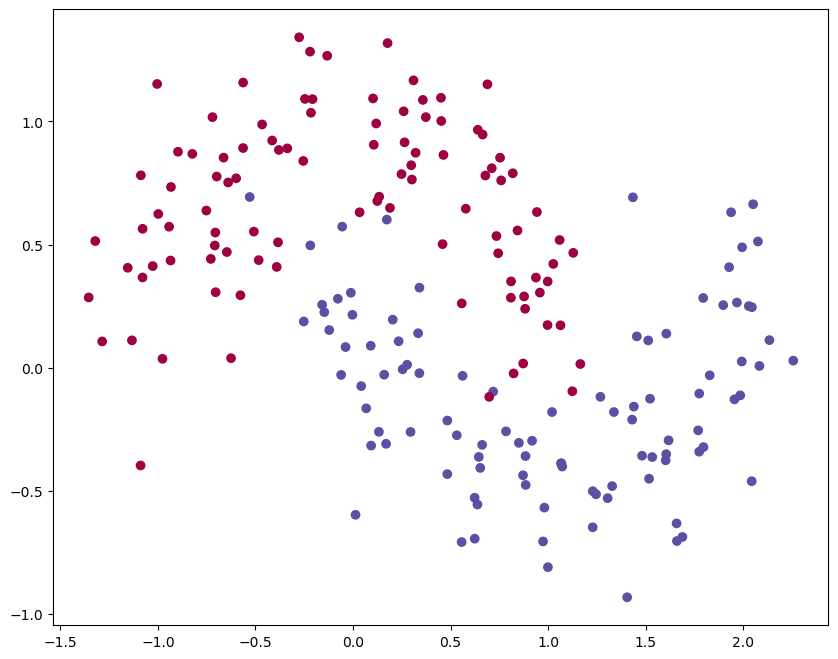

In [2]:
# Generate a dataset and plot it
# X: feature set, y: labels
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)

# plot the data
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

# create the one hot vector
num_classes=2
Y = np.zeros((len(y), num_classes))
for i in range(len(y)):
    Y[i, y[i]] = 1

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that's one of the major advantages of Neural Networks. The hidden layer of a neural network will learn features for you.

## 2. Helper function to plot the decision boundary

In [3]:
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## 3.  Training a Neural Network

Let's build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2 (because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able to fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are tanh, the sigmoid function, or ReLUs. We will use `tanh`, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the softmax, which is a generalization of the logistic function to multiple dimensions. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:
$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the cross-entropy loss. If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use gradient descent to find its minimum. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. We could also decay the learning rate over time (not done here).

### Implementation

We start by defining some useful variables and parameters for gradient descent:

In [4]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
lr = 0.001 # learning rate for gradient descent
lambda_reg = 0.01 # regularization strength

We define some usefull functions

In [5]:
def sigmoide(x):
    
    return 1/(1+np.exp(-x))

In [6]:
def softmax(x):
    expx=np.exp(x)
    return expx/expx.sum(axis=1,keepdims=True)

Let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [7]:
# Function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1)+b1
    a1 = sigmoide(z1)
    
    z2 = np.dot(a1,W2)+b2
    a2 = sigmoide(z2)
    
    z3 = np.dot(a2,W3)+b3
    a3 = softmax(z3)
    
    # Calculating the loss
    data_loss = np.sum(-Y*np.log(a3))
    
    # Add regulatization term to loss (optional)
    data_loss += lambda_reg/2*(np.sum(np.square(W1)) +np.sum(np.square(W2))+np.sum(np.square(W3)))
    
    return 1./num_examples * data_loss

We implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [8]:
# Function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation
    z1 = np.dot(x,W1)+b1
    a1 = sigmoide(z1)
    
    z2 = np.dot(a1,W2)+b2
    a2 = sigmoide(z2)
    
    z3 = np.dot(a2,W3)+b3
    a3 = softmax(z3)
    
    return np.argmax(a3, axis=1)

Here comes the function to train our Neural Network. Implement gradient descent using the backpropagation derivates.

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim,nn_hdim2, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim2) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim2))
    W3 = np.random.randn(nn_hdim2, nn_output_dim) / np.sqrt(nn_hdim2)
    b3 = np.zeros((1, nn_output_dim))


    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,W1)+b1
        a1 = sigmoide(z1)
        
        z2 = np.dot(a1,W2)+b2
        a2 = sigmoide(z2)
        
        z3 = np.dot(a2,W3)+b3
        a3 = softmax(z3)

        # Backpropagation
        delta3 = a3-Y
        dW3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = np.dot(delta3,W3.T)*(a2-np.power(a2,2))
        dW2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = np.dot(delta2,W2.T)*(a1-np.power(a1,2))
        dW1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW3+=lambda_reg*W3
        dW2+=lambda_reg*W2
        dW1+=lambda_reg*W1

        # Gradient descent parameter update
        W1+=-lr*dW1
        b1+=-lr*db1
        W2+=-lr*dW2
        b2+=-lr*db2
        W3+=-lr*dW3
        b3+=-lr*db3
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3': W3, 'b3': b3}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    return model

Let's see what happens if we train a network with a hidden layer size of 3.

Loss after iteration 0: 0.813573
Loss after iteration 1000: 0.305530
Loss after iteration 2000: 0.214655
Loss after iteration 3000: 0.123913
Loss after iteration 4000: 0.100784
Loss after iteration 5000: 0.092029
Loss after iteration 6000: 0.087630
Loss after iteration 7000: 0.084912
Loss after iteration 8000: 0.082917
Loss after iteration 9000: 0.081253
Loss after iteration 10000: 0.079768
Loss after iteration 11000: 0.078428
Loss after iteration 12000: 0.077244
Loss after iteration 13000: 0.076227
Loss after iteration 14000: 0.075374
Loss after iteration 15000: 0.074673
Loss after iteration 16000: 0.074105
Loss after iteration 17000: 0.073649
Loss after iteration 18000: 0.073282
Loss after iteration 19000: 0.072987
Loss after iteration 20000: 0.072747
Loss after iteration 21000: 0.072550
Loss after iteration 22000: 0.072387
Loss after iteration 23000: 0.072250
Loss after iteration 24000: 0.072134
Loss after iteration 25000: 0.072035
Loss after iteration 26000: 0.071949
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3 et 5')

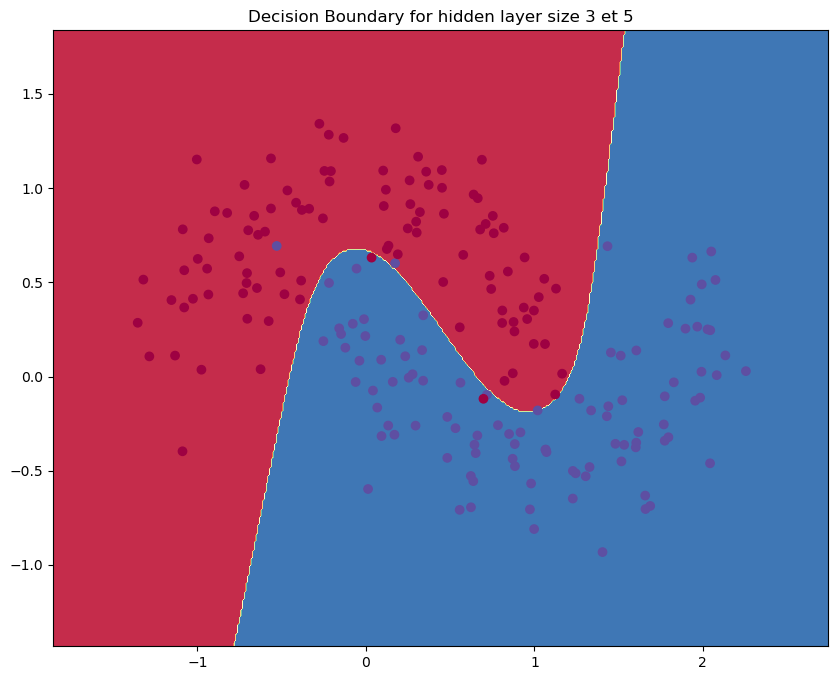

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3 ,5, num_passes=50000, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3 et 5")

### Comment

## 4. Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


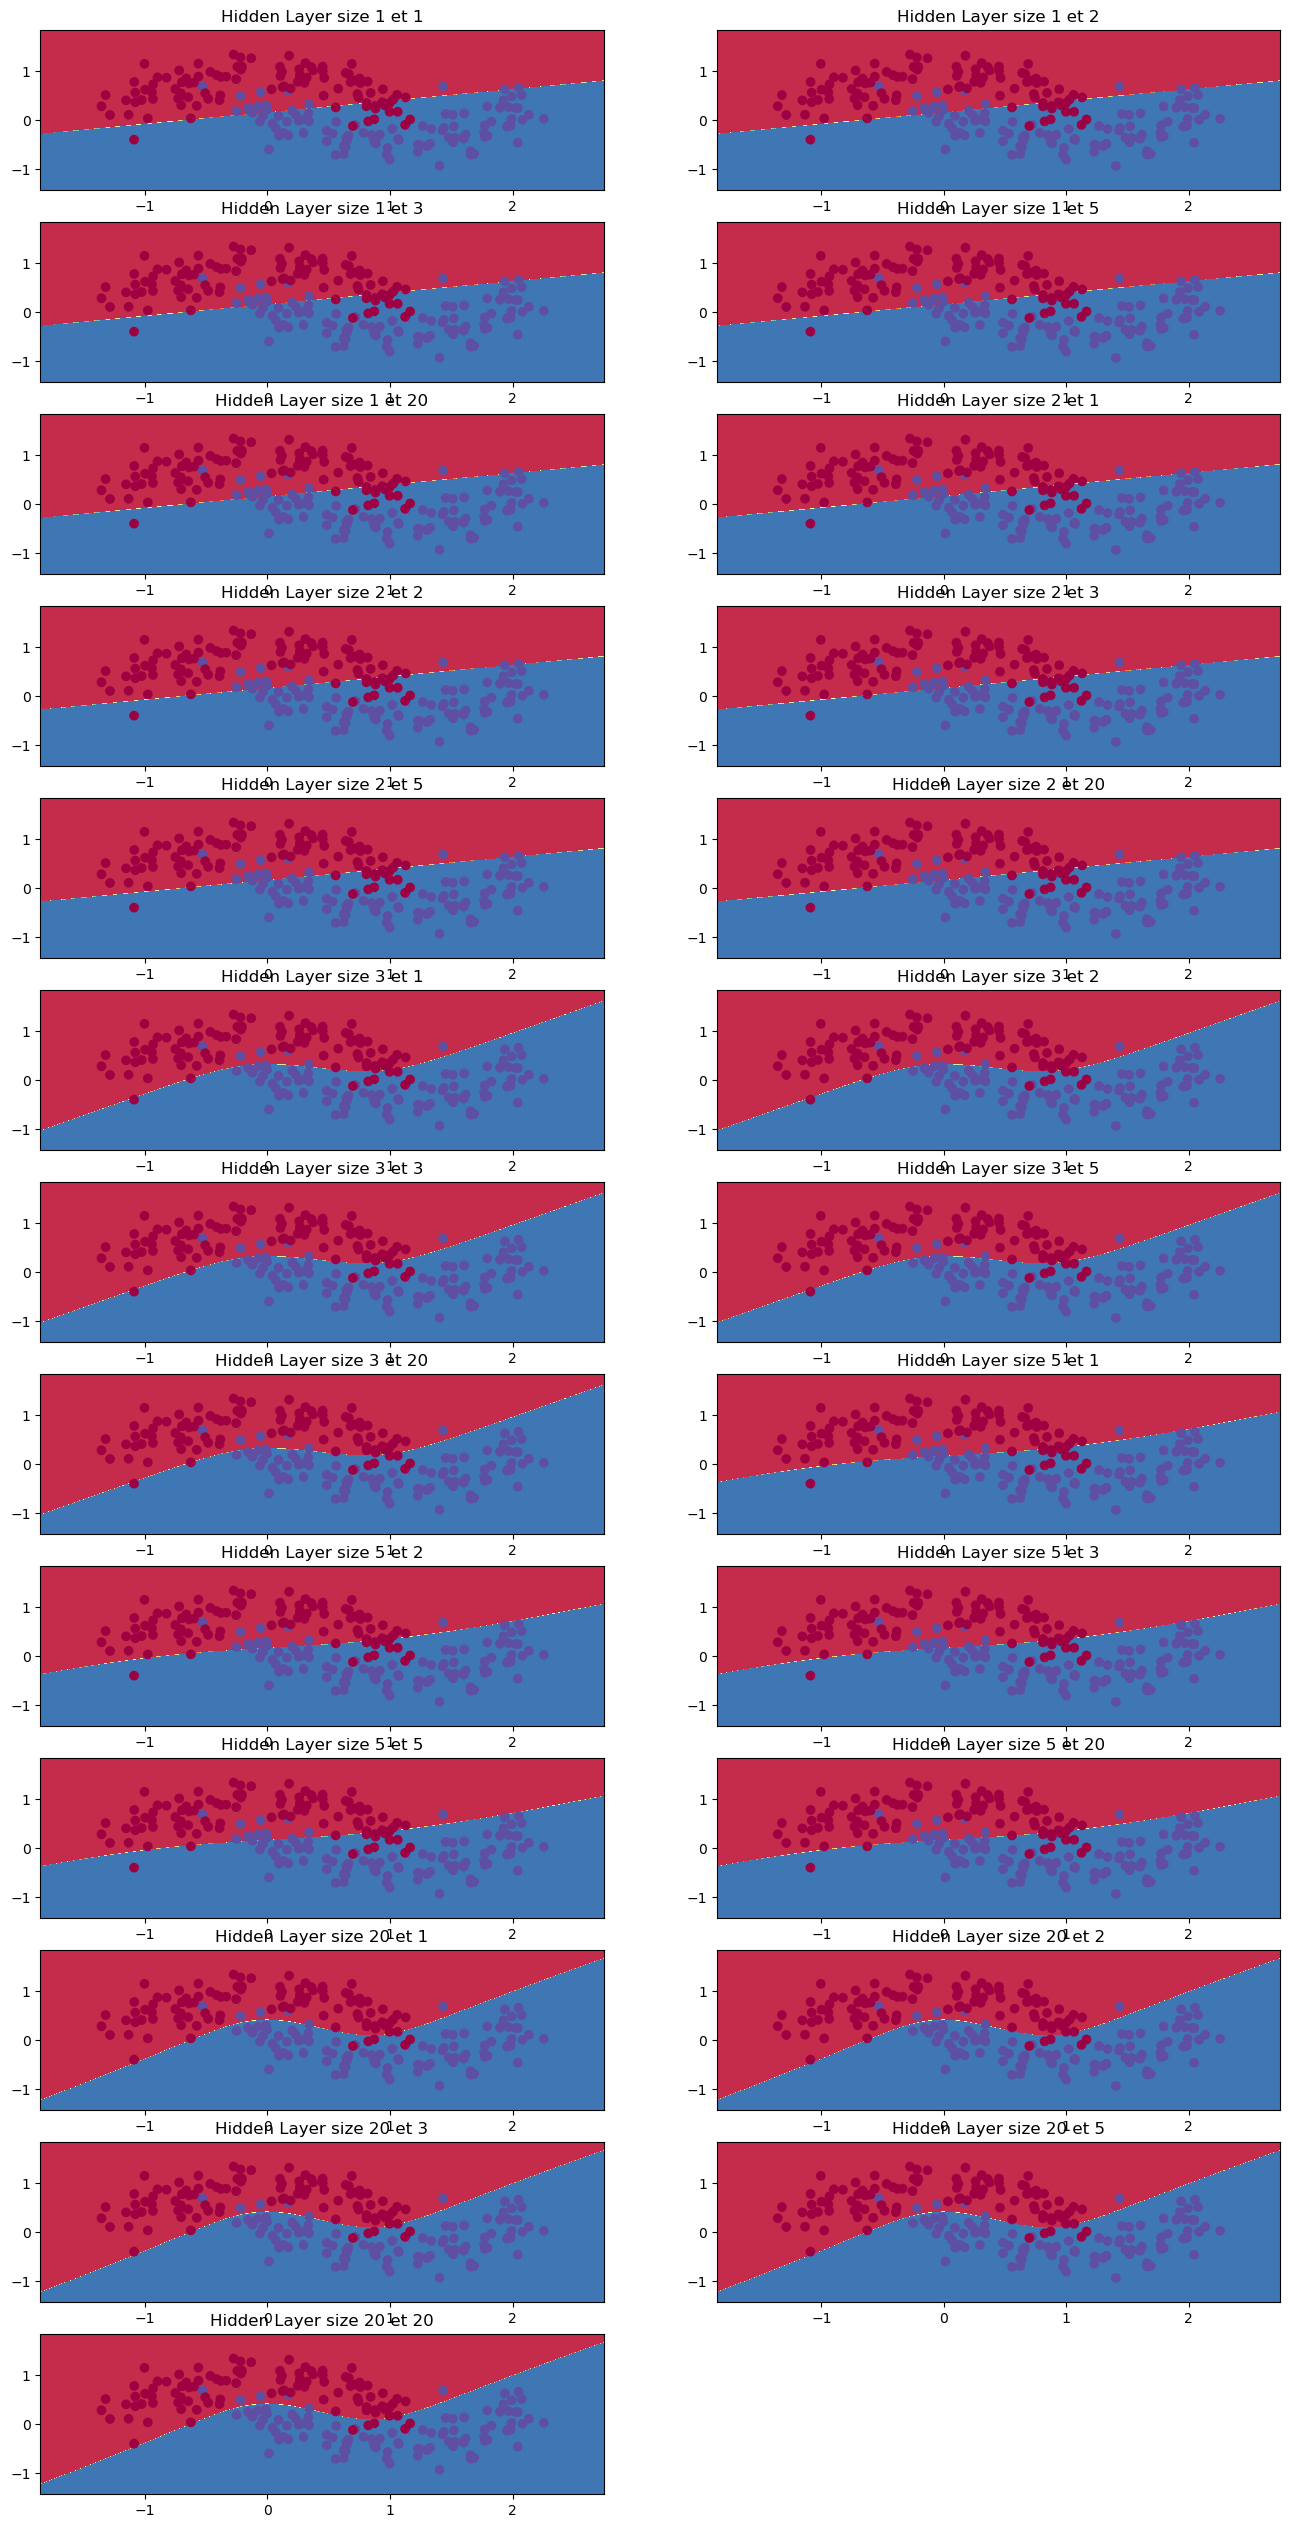

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3 ,5, 20]
for i,nn_hdim in enumerate(hidden_layer_dimensions):
    for j,nn_hdim_1,in enumerate(hidden_layer_dimensions):
        plt.subplot(13, 2,i*(len(hidden_layer_dimensions))+j+1)
        plt.title('Hidden Layer size %d et %d' % (nn_hdim,nn_hdim_1))
        model_i = build_model(nn_hdim,5,num_passes=2000)
        plot_decision_boundary(lambda x: predict(model_i, x))
plt.show()

### Comment

## 5. Prediction

We use the learned model in part 3 to do some predictions

In [12]:
# generate the graph. if there is a circle:
# - the marker inside the circle indicates the predicted classe 
# - and the contour of the circle indicates the true class
def plot_prediction(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

    for i in range(len(X_test)):
        if y_pred[i]==1:
            plt.scatter(X_test[i, 0], X_test[i, 1], s=90, facecolors='b')
            if compare[i] == False:
                plt.scatter(X_test[i, 0], X_test[i, 1], s=100, facecolors='none', edgecolors='r')
                
        else:
            plt.scatter(X_test[i, 0], X_test[i, 1], s=90, facecolors='r')
            if compare[i] == False:
                plt.scatter(X_test[i, 0], X_test[i, 1], s=100, facecolors='none', edgecolors='b')

taux bonne classif : 0.933333


Text(0.5, 1.0, 'Prediction from the hidden layer of size 3')

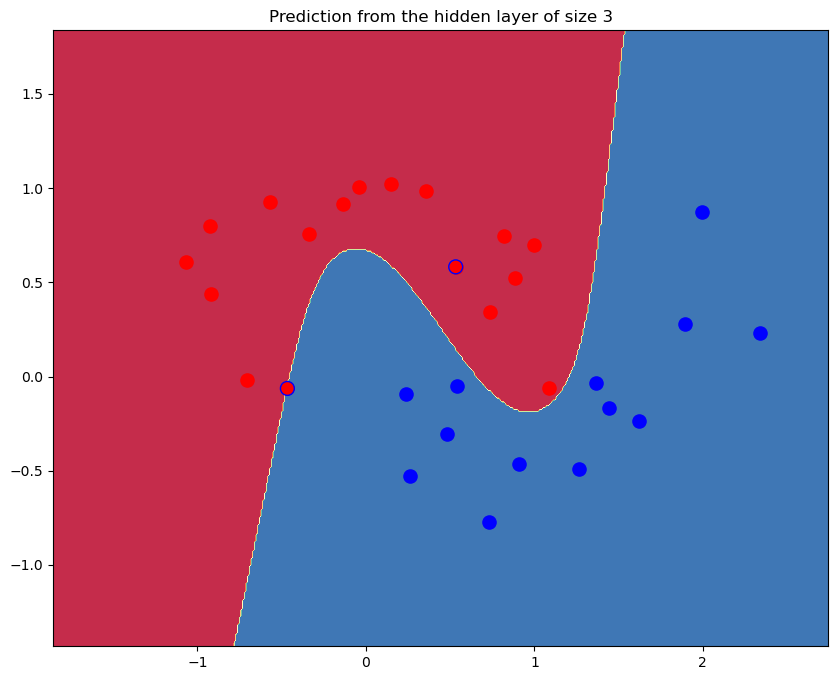

In [13]:
# generate new data
X_test, y_test = sklearn.datasets.make_moons(30, noise=0.20)

compare=np.zeros(len(X_test))
# do the prediction
y_pred = predict(model,X_test)

# compute the classification rate
classif_rate=0
nombre=0
for i in range(len(X_test)):
    if y_pred[i]==y_test[i]:
        nombre+=1
        compare[i]=True
classif_rate=nombre/len(X_test)
print("taux bonne classif : %f" % classif_rate)


# Plot the decision 
plot_prediction(lambda x: predict(model, x))
plt.title("Prediction from the hidden layer of size 3")

taux bonne classif : 0.933333


Text(0.5, 1.0, 'Prediction from the hidden layer of size 3')

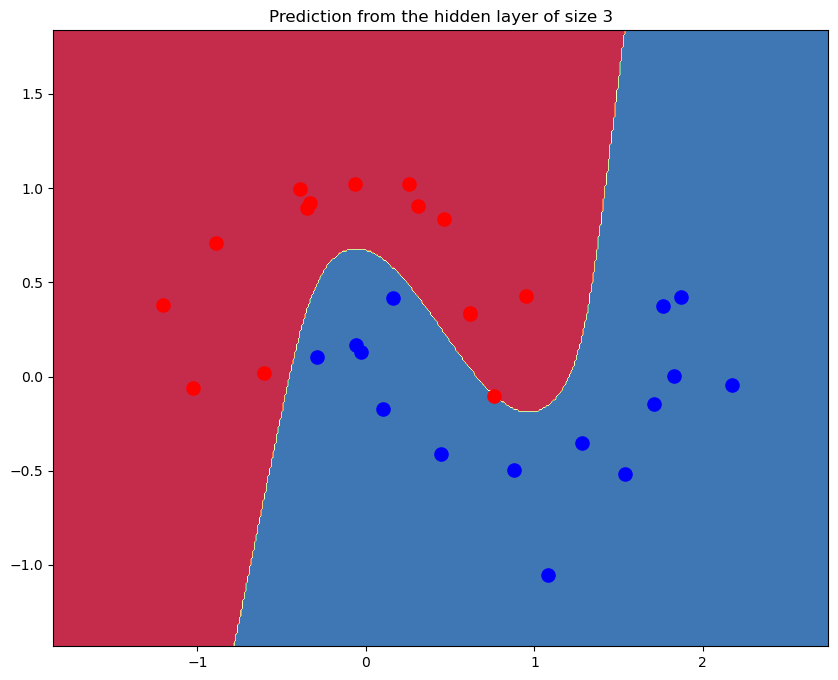

In [14]:
# generate new data
X_test, y_test = sklearn.datasets.make_moons(30, noise=0.20)

compare=np.zeros(len(X_test))
# do the prediction
y_pred = predict(model,X_test)

compare=(y_test==y_pred)
res=100*sum(y_test==y_pred)/len(X_test)

print("taux bonne classif : %f" % classif_rate)


# Plot the decision 
plot_prediction(lambda x: predict(model, x))
plt.title("Prediction from the hidden layer of size 3")

### Comment

## 6. Exercice complémentaire

1- Changer la fonction d'activation tanh par une sigmoïde.

2- Ajouter une couche cachée (les deux couches cachées auront les mêmes fonctions d'activation et le même nombre de neurones).